# Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
tf.__version__

'2.5.0-dev20201105'

In [3]:
import os 
print (os.getcwd())
print ('')
#Include the working directory path of the dataset folder 
os.chdir('C:\\Users\\Ibrahim Hameem\\Desktop\\Machine Learning\\7. Neural Nets\\Convolutional Neural Network\\Project Face Mask\\Mask_dataset')
print (os.getcwd())

C:\Users\Ibrahim Hameem\Desktop\Machine Learning\7. Neural Nets\Convolutional Neural Network\Project Face Mask

C:\Users\Ibrahim Hameem\Desktop\Machine Learning\7. Neural Nets\Convolutional Neural Network\Project Face Mask\Mask_dataset


# Image Preprocessing 

## Uploading the Training Set

In [4]:
Batch_size = 32
Img_size = (224,224)

train_dataset = image_dataset_from_directory('Training_dataset',
                                             batch_size = Batch_size,
                                            image_size = Img_size,
                                             shuffle = True)

Found 20171 files belonging to 2 classes.


### Visualizing the some uploaded images

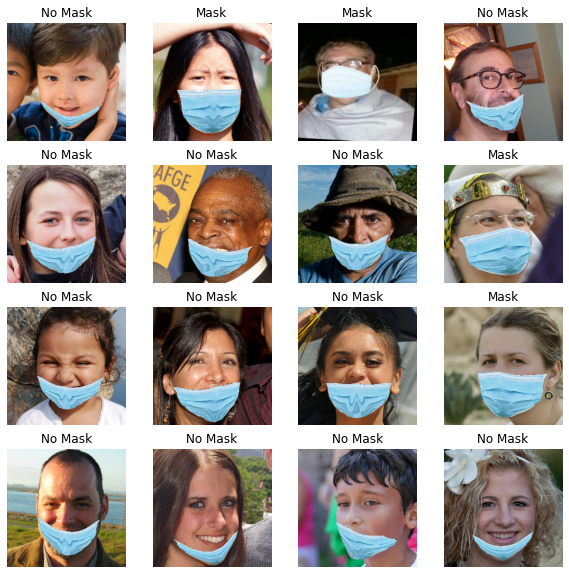

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize = (10,10))

for image, labels in train_dataset.take(1):
    for i in range (0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Uploading the Validation Set

In [6]:
validation_dataset = image_dataset_from_directory('Testing_dataset',
                                             batch_size = Batch_size,
                                            image_size = Img_size,
                                             shuffle = True)

Found 5277 files belonging to 2 classes.


### Creating a Test Set using the Validation set

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

test_dataset = validation_dataset.take(val_batches // 5)

validation_dataset = validation_dataset.skip(val_batches // 5)

print ('Number of Vaidation batches:%d' % tf.data.experimental.cardinality(validation_dataset))
print ('')
print ('Number of Test batches:%d' % tf.data.experimental.cardinality(test_dataset))

Number of Vaidation batches:132

Number of Test batches:33


### Configure the data to improve performance

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

### Creating the data augmentation instance

In [9]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                        tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
                                        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(-0.7),
                                        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1)])

#### Visualizing an image subject to the above data augmentation procedures

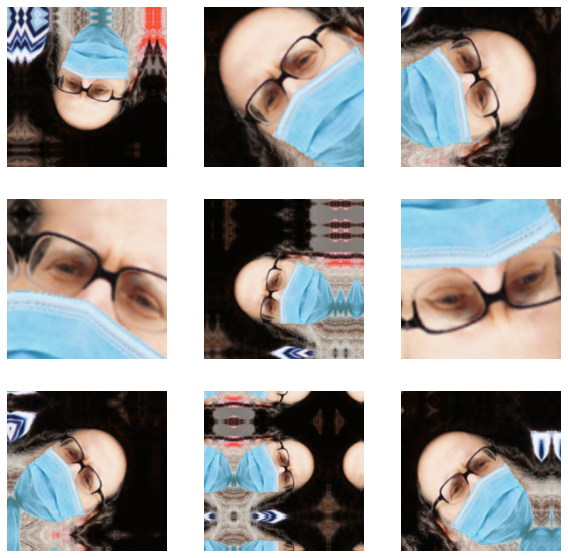

In [10]:
plt.figure(figsize=(10, 10))

for image,_ in train_dataset.take(1):
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))#We add a dummy dimension to account for batches 
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

### Creating the Rescaling instance

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel vaues in [-1,1], but at this point, the pixel values in your images are in [0-255]. To rescale them, use the preprocessing method included with the model.

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Creating the base model from pre-trained Convnets

MobileNet V2 model was developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base knowledge will help us classify if an individual is wearing a mask or not wearing a mask or wearing a mask incorrectly 

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction

In [12]:
# Create the base model from the pre-trained model MobileNet V2 (Google)

IMG_SHAPE = Img_size + (3,)

base_model = tf.keras.applications.MobileNetV2 (input_shape = IMG_SHAPE, 
                                                include_top = False,
                                                weights = 'imagenet')

Basically we have taken the Convolutional layers and its pre-trained weight leading upto the flattened later prior to the fully connected layers

This feature extractor converts each 224x224x3 image into a 7x7x1280 block of features. Let's see what it does to an example batch of images:

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


### Feature Extraction

In this step, you will freeze most of the convolutional base created from the previous step. This is becuase the base model has been trained on the images on ImageNet, which does not include the images of humans with or without a mask. However all is not lost and we can still use the pre-trained MobileNet V2 to a large extent. This is becuase in most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning

Hence we will freeze the first 75 inital layers of the MobileNet V2 architecture and train the remanining layers, inluding the new layers added by us on top of the base_model 

In [14]:
base_model.trainable = True

In [15]:
print("Number of layers in the base model: ", len(base_model.layers))
print ('')

fine_tune_at = 75

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154



Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In order to generate predictions from the block of features, average over the spatial 7 x 7 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image - This is a feature of the MobileNet V2 architecture

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#Testing the above line of code on the feature batch created 
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.

In [18]:
#Flatten layer 

Flatten_layer = tf.keras.layers.Flatten(name = 'flatten')

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting

In [19]:
#Bulding a shell model that will be fitted on the dataset
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Flatten_layer(x)
x = tf.keras.layers.Dense(units = 128, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss

In [20]:
base_learning_rate = 0.0001/10
model.compile(optimizer = tf.keras.optimizers.Adam(lr = base_learning_rate), 
             loss = 'binary_crossentropy', 
             metrics = ['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968

We can see that the 2,231,809 parameters of the base model is trainable.

# Train the model

In [22]:
#Evaluating the half-baked model on the validation set prior to training it
loss0, accuracy0 = model.evaluate(validation_dataset)

132/132 [==============================] - 79s 503ms/step - loss: 0.7149 - accuracy: 0.5354


In [23]:
history = model.fit(x = train_dataset, validation_data = validation_dataset, epochs = 17)

Epoch 1/17
631/631 [==============================] - 568s 892ms/step - loss: 0.2441 - accuracy: 0.8947 - val_loss: 0.1366 - val_accuracy: 0.9479
Epoch 2/17
631/631 [==============================] - 587s 928ms/step - loss: 0.0865 - accuracy: 0.9700 - val_loss: 0.1186 - val_accuracy: 0.9531
Epoch 3/17
631/631 [==============================] - 578s 913ms/step - loss: 0.0649 - accuracy: 0.9766 - val_loss: 0.1040 - val_accuracy: 0.9642
Epoch 4/17
631/631 [==============================] - 644s 1s/step - loss: 0.0534 - accuracy: 0.9808 - val_loss: 0.1041 - val_accuracy: 0.9635
Epoch 5/17
631/631 [==============================] - 617s 976ms/step - loss: 0.0416 - accuracy: 0.9852 - val_loss: 0.0871 - val_accuracy: 0.9678
Epoch 6/17
631/631 [==============================] - 639s 1s/step - loss: 0.0409 - accuracy: 0.9859 - val_loss: 0.0936 - val_accuracy: 0.9711
Epoch 7/17
631/631 [==============================] - 588s 929ms/step - loss: 0.0352 - accuracy: 0.9881 - val_loss: 0.0724 - val_a



# Learning curves

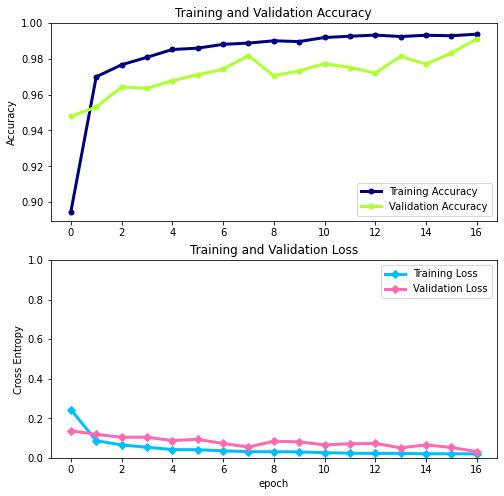

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth = 3, marker = 'o', ms = 5, color = 'navy')
plt.plot(val_acc, label='Validation Accuracy',linewidth = 3, marker = 'o', ms = 5, color = 'greenyellow')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss',linewidth = 3, marker = 'D', ms = 5, color = 'deepskyblue')
plt.plot(val_loss, label='Validation Loss',linewidth = 3, marker = 'D', ms = 5, color = 'hotpink')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Using the trained model to predict if an image is wearing a mask or not

Predictions:
 [0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1]
Labels:
 [0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1]



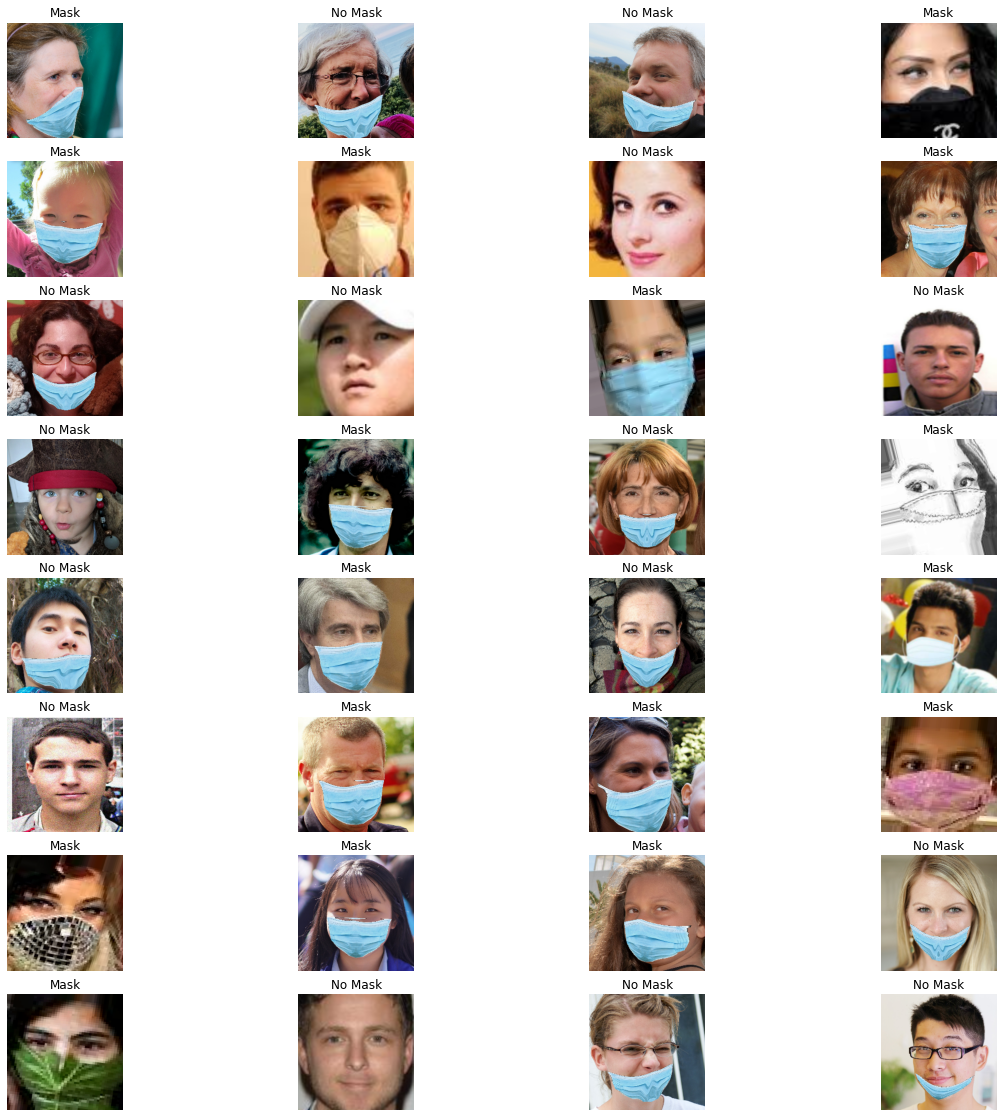

In [25]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

#Make predictions on the batch of images
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
print ('')

plt.figure(figsize=(20, 20))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [26]:
#Include the path to the folder where the trained model needs to be saved (This could be anywhere in your computer)
os.chdir('C:\\Users\\Ibrahim Hameem\\Desktop\\Machine Learning\\7. Neural Nets\\Convolutional Neural Network\\Project Face Mask')
model.save('mask_model_pre-trained_1.h5')